In [9]:
import pandas as pd
import numpy as np
import torch as t
import plotly.graph_objects as go
import seaborn as sns

In [2]:
# load in clean dataset
clean_data = pd.read_csv(r"/home/tobi/Desktop/Capstone/EnergyDemandForecasting/src/Saved/Datasets/clean_training.csv", index_col=0)
display(clean_data)

,Energy Demand (MWH),HourlyDryBulbTemperature,HourlyDewPointTemperature,HourlyStationPressure,HourlyPrecipitation,HourlyWindSpeed,Energy Price (cents/KWH),Labor Force Level,Civilian Noninstitutional Population,Labor Force Participation
2018-06-19 05:00:00,7221.0,78.0,72.0,29.62,NaN,6.000000,19.28,4272100.0,7105823.0,60.1
2018-06-19 06:00:00,6911.0,79.0,70.0,29.63,NaN,6.000000,19.28,4272100.0,7105823.0,60.1
2018-06-19 07:00:00,6691.0,81.0,69.0,29.63,NaN,3.544254,19.28,4272100.0,7105823.0,60.1
2018-06-19 08:00:00,6582.0,82.0,67.0,29.63,NaN,3.789006,19.28,4272100.0,7105823.0,60.1
2018-06-19 09:00:00,6600.0,81.0,69.0,29.65,NaN,7.000000,19.28,4272100.0,7105823.0,60.1
...,...,...,...,...,...,...,...,...,...,...
2023-08-05 14:00:00,6168.0,84.0,58.0,29.81,NaN,6.000000,22.33,4165918.0,6747734.0,61.7
2023-08-05 15:00:00,6431.0,83.0,60.0,29.82,NaN,7.000000,22.33,4165918.0,6747734.0,61.7
2023-08-05 16:00:00,6599.0,82.0,55.0,29.82,NaN,0.000000,22.33,4165918.0,6747734.0,61.7
2023-08-05 17:00:00,6745.0,81.0,56.0,29.82,NaN,5.000000,22.33,4165918.0,6747734.0,61.7


In [ ]:
# encode hour of the day, day of the week, and day of the year in terms of sine and cosine

# should also try doing this without sine and cosine and compare the difference

In [2]:
if t.cuda.is_available():
    device = t.device("cuda")
    print("PyTorch is using:", t.cuda.get_device_name(0))
else:
    print("PyTorch is using CPU")

PyTorch is using: Radeon RX 7900 XTX


In [4]:
# test using gpu
test = t.randn(32, 5, device="cuda")
display(test.device)

device(type='cuda', index=0)

In [6]:
import numpy as np

class LSTMWithTimeEncoding(t.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMWithTimeEncoding, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = t.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = t.nn.Linear(hidden_size, output_size)

    def forward(self, x, time_encoding):
        # Initialize hidden state and cell state
        h0 = t.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = t.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Concatenate time encoding with input features
        x = t.cat([x, time_encoding], dim=-1)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage:
input_size = 10  # Number of features in the input
hidden_size = 32  # Number of LSTM units (hidden size)
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of output predictions
seq_length = 24  # Length of input sequence (assuming hourly data)

# Initialize the LSTM model
model = LSTMWithTimeEncoding(input_size + 4, hidden_size, num_layers, output_size)  # Additional 4 for time encoding

# Example input tensor (batch_size, seq_length, input_size)
input_tensor = t.randn(32, seq_length, input_size)

# Example time encoding for hour of the day and day of the week
hour_of_day = np.arange(seq_length) % 24
day_of_week = np.arange(seq_length) // 24 % 7

# Calculate sine and cosine encodings
hour_encoding = np.column_stack([np.sin(2 * np.pi * hour_of_day / 24), np.cos(2 * np.pi * hour_of_day / 24)])
day_encoding = np.column_stack([np.sin(2 * np.pi * day_of_week / 7), np.cos(2 * np.pi * day_of_week / 7)])

# Repeat encodings for each sample in the batch
hour_encoding = np.tile(hour_encoding, (input_tensor.shape[0], 1, 1))
day_encoding = np.tile(day_encoding, (input_tensor.shape[0], 1, 1))

# Convert encodings to PyTorch tensors
hour_encoding = t.FloatTensor(hour_encoding)
day_encoding = t.FloatTensor(day_encoding)

display(hour_encoding.shape)
# Forward pass
output = model(input_tensor, t.cat([hour_encoding, day_encoding], dim=-1))
print("Output shape:", output.shape)


torch.Size([32, 24, 2])

Output shape: torch.Size([32, 1])


In [8]:
display(hour_encoding[0,:,0])
display(hour_encoding[1,:,1])

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01,  1.2246e-16, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01])

tensor([ 1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,  5.0000e-01,
         2.5882e-01,  6.1232e-17, -2.5882e-01, -5.0000e-01, -7.0711e-01,
        -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01, -8.6603e-01,
        -7.0711e-01, -5.0000e-01, -2.5882e-01, -1.8370e-16,  2.5882e-01,
         5.0000e-01,  7.0711e-01,  8.6603e-01,  9.6593e-01])

<Axes: >

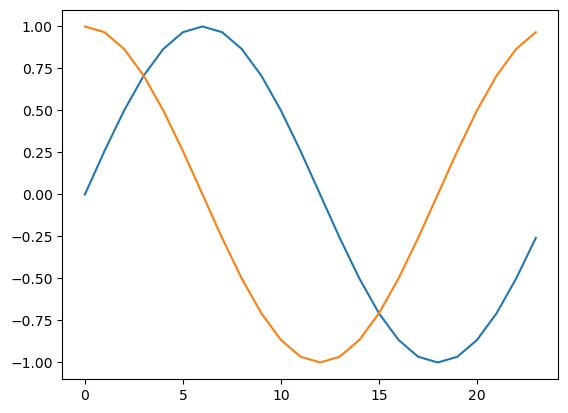

In [11]:
sns.lineplot(data=hour_encoding[0,:,0])
sns.lineplot(data=hour_encoding[1,:,1])